In [66]:
import multiprocessing
import numpy as np
from math import *
import matplotlib.pyplot as plt
from functools import partial
from scipy.interpolate import griddata
from PIL import Image
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

(204, 204)

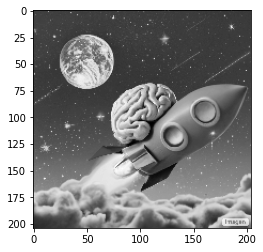

In [80]:
image = Image.open('image.jpg')
pixel_size = 5 #reduzco complejidad
ancho, alto = image.size
nuevo_ancho = ancho // pixel_size
nuevo_alto = alto // pixel_size
imagen_pixelada = image.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
image = imagen_pixelada.convert('L')
image = np.array(image)
#image = np.random.rand(2,2)
plt.imshow(image,cmap='gray')
image.shape

In [81]:
class GCell:
    def __init__(self):
        self.recprof = lambda posiciones : np.exp(-((posiciones[:,:,0])**2 + (posiciones[:,:,1])**2)) * np.exp(2j*(posiciones[:,:,1]))
        
def Accion(posiciones,x,y,phi):
    return np.add(np.matmul(posiciones,np.array([[cos(phi),-sin(phi)],[sin(phi),cos(phi)]])), np.array([x,y]))

def AccionInv(posiciones,x,y,phi):
    #devuelve el punto con la rotacion inversa y desplazado -
    return np.matmul((posiciones - np.array([x,y])), np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]))
    #return (posiciones - np.array([x,y])) @ np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]) #no mejora el rendimiento

def O(x,y,phi,imagen,gcell,posiciones):
    #debería cambiar la suma por algo mejor? que aproxime mejor la integral
    return np.sum(imagen * gcell.recprof(posiciones))

class V1:
    def __init__(self, height, width, imagen):
        #inicio un tablero con las células ganglionares bajo la acción del grupo E(2), rotaciones y traslaciones en el plano
        # estaria bien hacer que no dependiera de la imagen elegida (se adapte al tamaño)
        #imagen: 
        self.n = imagen.shape[0]
        #posiciones es una discretacizacion del plano por puntos con coordenadas (i,j) habrá que crear células ganglionales con distintas posiciones
        posiciones = np.array(list(product(np.arange(1,self.n+1),repeat=2))).reshape((self.n,self.n,2))
        self.reticulo = None
        pass

def searchPhiP(x,y,imagen,gcell):
    posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))
    #posicionesRotTrans = lambda phi : AccionInv(posiciones,x,y,phi) #rotamos y trasladamos
    
    espacioBusqueda = np.linspace(0,pi,15) #bajo los cortes, las fibras son S1 pero modulo pi
    #espacioBusqueda = np.linspace(0,2*pi,20) #bajo los cortes tomamos las fibras como S1; asi no sale
    
    #parcializo las funciones para el map
    #     aI = partial(AccionInv, posiciones, x, y)
    #     o = partial(O, x=x, y=y, imagen=imagen, gcell=gcell)
    
    acciones = np.array([AccionInv(posiciones,x,y,phi) for phi in espacioBusqueda])
    
    def os(t):
        return O(x,y,t[0],imagen,gcell,t[1])
    
    Os = []
    
    #cuidado con el orden, no se si devuelve bien el orden de phi
    with ThreadPoolExecutor() as executor:
        #resultados = [executor.submit(os,t) for t in zip(espacioBusqueda,acciones)]
        resultados = executor.map(os, zip(espacioBusqueda,acciones))
        for res in resultados:
            #Os.append(res.result())
            Os.append(res)
        
    #Os = Parallel(n_jobs=-1)(delayed(O)(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi)) for phi in espacioBusqueda)
    Os = np.abs(Os)
    #return espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))]
    return espacioBusqueda[np.argmax(np.array(Os))]

def allPhiP(imagen,gcell):
    arr = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])
    prefdOr = {(x,y):searchPhiP(x,y,imagen,gcell) for x,y in arr}
    return prefdOr

def scatterDict(datos,image,plotProyection):
    x = np.array([coord[0] for coord in datos.keys()])
    y = np.array([coord[1] for coord in datos.keys()])
    z = np.array(list(datos.values()))
    
    mycmap = 'viridis'
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(2, 2, 1)
    scatter1 = ax1.scatter(y, -x, c=z, cmap=mycmap) #invierto, si no sale al reves
    ax1.set_aspect('equal')
    ax1.set_xlabel('Eje X')
    ax1.set_ylabel('Eje Y')
    ax1.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter1, ax=ax1, label='Orientación preferida [0,pi]',fraction=0.046, pad=0.04)
    
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    if plotProyection:
        z_ = np.zeros(np.array(list(datos.values())).shape) #sirve para visualizar la proyección de los puntos
        scatter2 = ax2.scatter(x, y, z_, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    else:
        scatter2 = ax2.scatter(x, y, z, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    ax2.set_xlabel('Eje X')
    ax2.set_ylabel('Eje Y')
    ax2.set_zlabel('PhiP')
    ax2.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter2, ax=ax2, label='Altura = PhiP',fraction=0.046, pad=0.04)
    plt.tight_layout()
    
    ax3 = fig.add_subplot(2, 2, 3)
    x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')
    ax3.imshow(z_grid.T, cmap=mycmap) #traspongo la matriz imagen para que este bien orientada
    ax3.set_title('Interpolación de los puntos')
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.imshow(image, cmap = 'gray')
    
    plt.show()

In [82]:
mycell = GCell()
%time mydict = allPhiP(image,mycell)

CPU times: total: 36min 29s
Wall time: 27min 7s


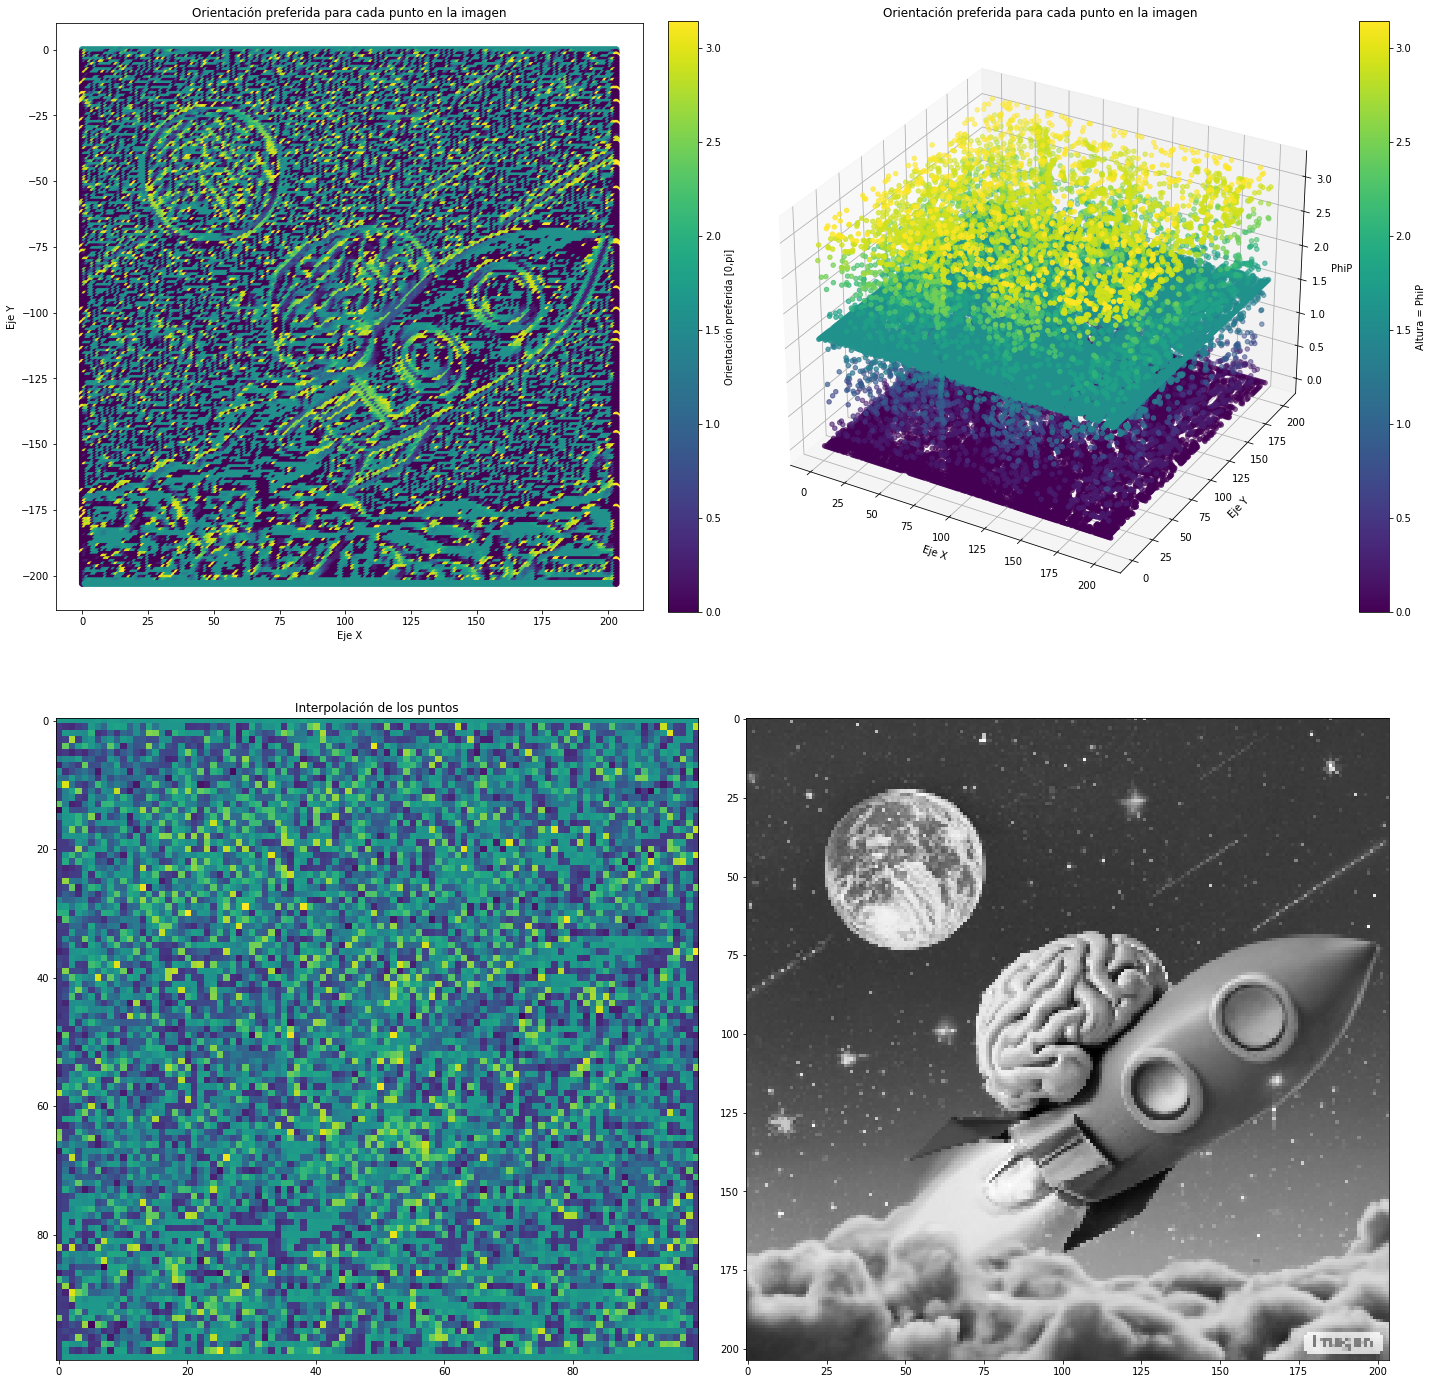

In [83]:
scatterDict(mydict,image,False)

In [6]:
with open('im2arrayv3.json', 'w') as file:
    json.dump({str(k): v for k, v in mydict.items()}, file, indent=4)

In [106]:
with open('im2array.json') as file:
    aux = json.load(file)

In [141]:
mydict2 = {eval(k):v for k,v in aux.items()}

In [12]:
imagen = image
x,y = 5,5
gcell = GCell()
posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))
#posicionesRotTrans = lambda phi : AccionInv(posiciones,x,y,phi) #rotamos y trasladamos

espacioBusqueda = np.linspace(0,pi,15) #bajo los cortes, las fibras son S1 pero modulo pi
#espacioBusqueda = np.linspace(0,2*pi,20) #bajo los cortes tomamos las fibras como S1; asi no sale

#parcializo las funciones para el map
aI = partial(AccionInv, posiciones, x, y)
o = partial(O, x=x, y=y, imagen=imagen, gcell=gcell, posiciones=posiciones)

#Os
# Os = []
# #intento paralelizar
# with ThreadPoolExecutor() as executor:
#     future_to_posiciones_inversas = executor.imap(aI, espacioBusqueda) #necesito guardar el orden
#     #Os = pool.map(o, posiciones_inversas)
#     for pos in posiciones_inversas:
#         print(pos)
#Os = Parallel(n_jobs=-1)(delayed(O)(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi)) for phi in espacioBusqueda)
#Os = np.abs(Os)
#return espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))]
# print(espacioBusqueda[np.argmax(Os)])

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        else:
            print('%r page is %d bytes' % (url, len(data)))

In [15]:
%time acciones = np.array([AccionInv(posiciones,x,y,phi) for phi in espacioBusqueda])

CPU times: total: 266 ms
Wall time: 323 ms


In [21]:
%time [np.abs(O(x,y,phi,imagen,gcell,pos)) for phi,pos in zip(espacioBusqueda,acciones)]

CPU times: total: 1.66 s
Wall time: 1.84 s


[72.11867067272763,
 72.01007401934108,
 71.59769081245251,
 71.30343689784895,
 71.37825293528849,
 71.82596813110636,
 72.38772615018539,
 72.6054059864928,
 72.22137070619208,
 71.48514938298305,
 70.8815441899655,
 70.73338114211684,
 71.09494644968957,
 71.71678618654276,
 72.11867067272763]

In [44]:
import time
a = time.time()
aux = []

def os(t):
    return O(x,y,t[0],imagen,gcell,t[1])

with ThreadPoolExecutor() as executor:
    resultado = [executor.submit(os,t) for t in zip(espacioBusqueda,acciones)]
    for res in resultado:
        aux.append(res.result())
print(aux)        
print(time.time()-a)

[(72.11248164358697-0.9448019923111722j), (72.00132854426884-1.1222513672248953j), (71.58729229205903-1.2202098044400307j), (71.29335328158896-1.1991210581401375j), (71.3703561148312-1.0617250756175116j), (71.82106250552025-0.8394513379944595j), (72.38548109455176-0.5701086778173352j), (72.60482287695848-0.290987059731607j), (72.22136043918519-0.0385096678227971j), (71.48496311747914+0.16318823502432114j), (70.88084078022004+0.31578005498593814j), (70.73198673121003+0.44414057673156543j), (71.09257229881018+0.581011723354205j), (71.71286756041914+0.749698064605602j), (72.11248164358697+0.9448019923111722j)]
0.6306037902832031


In [28]:
z = [i for i in zip(range(3),range(3))]

In [70]:
zip(espacioBusqueda,acciones)